In [1]:
import pandas as pd

def load_data(df):
    return pd.read_csv(file_path)

file_path = '../data/flight_df.csv' # period indicates getting out from directory to others

# Load dataset
df = load_data(file_path)
df.head()

,Age,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,...,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,Gender_Male,Loyal Customer,Business Travel,satisfied
0,26,3,2062,2,3,3,3,2,2,2,...,3,3,3,2,0,0,0,1,1,0
1,52,3,680,5,5,5,5,3,4,4,...,4,4,4,4,18,2,0,1,1,1
2,28,1,188,3,5,3,4,3,3,3,...,4,4,5,3,0,0,1,1,0,0
3,54,3,453,3,5,5,5,3,4,4,...,3,4,3,1,91,80,0,1,1,0
4,40,1,775,4,3,3,3,4,4,4,...,3,3,3,4,0,0,1,1,1,0


In [2]:
from sklearn.model_selection import train_test_split

# Define target and features
y=df['satisfied']
X= df.drop(columns='satisfied')

# Split dataset
X_train, X_test,y_train,y_test = train_test_split(X,y, test_size=0.2, random_state=42)

y.value_counts(normalize=True)

satisfied
0    0.56695
1    0.43305
Name: proportion, dtype: float64

In [3]:
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline

def create_preprocessing_pipeline():

    # Select numeric and categorical
    num_cols = make_column_selector(dtype_include='number')
    cat_cols = make_column_selector(dtype_include='object')

    # instantiate transformers
    scaler = StandardScaler()
    ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    knn_imputer = KNNImputer(n_neighbors=2, weights='uniform')

    # Create pipeline 
    num_pipe =Pipeline([
        ('imputer',knn_imputer),
        ('scaler', scaler),
    ])

    cat_pipe =Pipeline([
        ('encoder', ohe)
    ])

    preprocessor = ColumnTransformer([
        ('numeric', num_pipe,num_cols),
        ('categorical',cat_pipe,cat_cols),
    ], remainder='drop')

    return preprocessor

# Create preprocessor object
preprocessor = create_preprocessing_pipeline()

In [4]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Create sampler pipeline
def make_sampler_pipeline(sampler):
    return ImbPipeline([
        ('sampler',sampler)
    ])

# Preprocess and rebalance data
def preprocess_and_rebalance_data(preprocessor, X_train,X_test,y_train):

    # Transform training data into fitted transformer
    X_train_transformed = preprocessor.fit_transform(X_train)
    X_test_transformed= preprocessor.transform(X_test)

    # Create sampling pipeline
    sampler = make_sampler_pipeline(SMOTE(random_state=42))

    X_train_balanced,y_train_balanced= sampler.fit_resample(X_train_transformed,y_train)

    return X_train_balanced,X_test_transformed,y_train_balanced

    # Balance training data
X_train_balanced,X_test_transformed,y_train_balanced = preprocess_and_rebalance_data(preprocessor,X_train,X_test,y_train)

In [5]:
# Convert 
X_train_balanced_df =pd.DataFrame(X_train_balanced)
X_test_transformed_df = pd.DataFrame(X_test_transformed)

#### MACHINE LEARNING

In [6]:
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.metrics import(
    accuracy_score,recall_score,precision_score, f1_score,classification_report, confusion_matrix, ConfusionMatrixDisplay
)

def evaluate_model(model,X_train, y_train, X_test, y_test):

    train_preds= np.rint(model.predict(X_train)) # np.rint = round to the nearest INT
    test_preds= np.rint(model.predict(X_test))

    # Class report
    train_report = classification_report(y_train,train_preds)
    test_report = classification_report(y_test,test_preds)

    # Confusion matrix 
    cm_train = confusion_matrix(y_train,train_preds)
    cm_test = confusion_matrix(y_test,test_preds)

    # Formal all figures in dark mode
    plt.style.use('dark_background')

    # plot train summary and confusion matrix
    fig, axes = plt.subplots(1,2,figsize=(14,5))

    #First axes
    axes[0].text(0.01,0.05,str(train_report),{'fontsize':12}, fontproperties='monospace')
    axes[0].axis('off')

    # Second Axes
    disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train)
    disp_train.plot(ax=axes[1],cmap='Blues')
    axes[1].set_title('Confusion Matrix-Training Set ')

    # plot test summary and confusion matrix
    fig, axes = plt.subplots(1,2,figsize=(14,5))

    #First axes
    axes[0].text(0.01,0.05,str(test_report),{'fontsize':12}, fontproperties='monospace')
    axes[0].axis('off')

    # Second Axes
    disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train)
    disp_train.plot(ax=axes[1],cmap='Purples')
    axes[1].set_title('Confusion Matrix-Test Set ')

    plt.show()

    return train_report, test_report

In [7]:
from sklearn.pipeline import Pipeline

# Create ML pipeline
def train_and_predict_model(X_train,y_train,X_test,preprocessor,model):

    # Combine preprocessing pipeline and model
    model_pipe =Pipeline(steps=[
        ('preprocessor',preprocessor),
        ('classifier',model),
    ])
 
    # Fit pipeline
    model_pipe.fit(X_train,y_train)
    
    # Create predictions
    train_preds = model_pipe.predict(X_train)
    test_preds=model_pipe.predict(X_test)

    return train_preds,test_preds

In [8]:
import lightgbm as lgb

# Instantiate the model
lgbm_model = lgb.LGBMClassifier(verbose=-1,random_state=42)

# Create predictions
train_preds, test_preds = train_and_predict_model(X_train_balanced_df,y_train_balanced,X_test_transformed_df,preprocessor,lgbm_model)

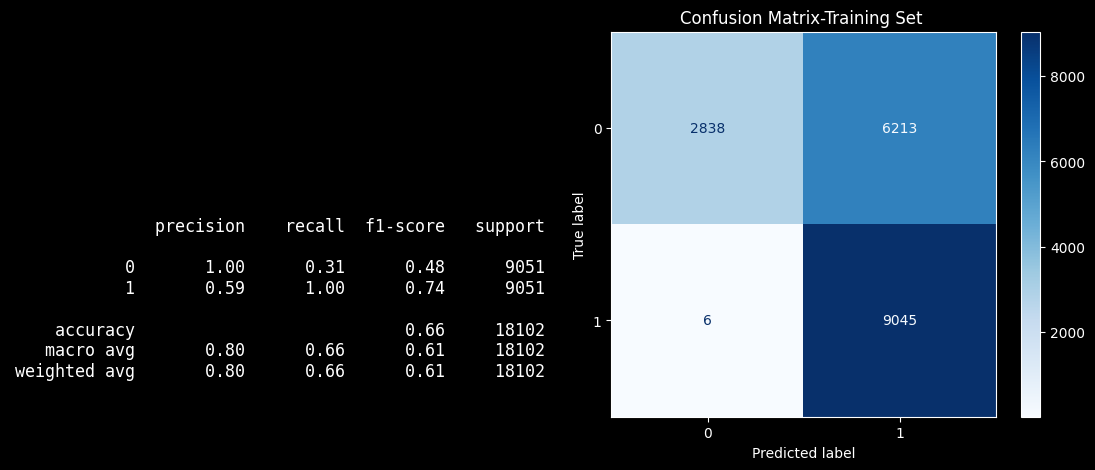

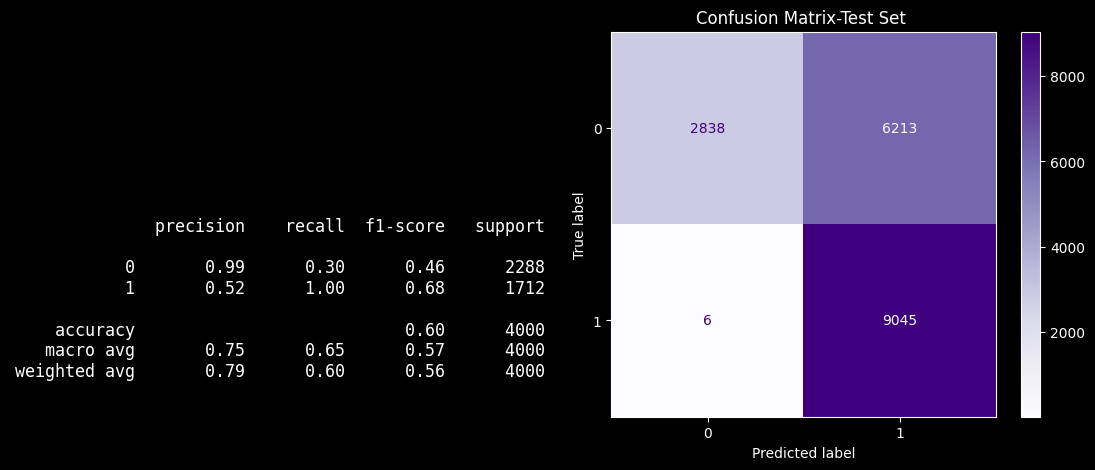

In [9]:
train_report, test_report = evaluate_model(lgbm_model,X_train_balanced_df,y_train_balanced,X_test_transformed_df,y_test)

In [10]:
from sklearn.tree import DecisionTreeClassifier

# Instantiate the Classifier
dec_tree = DecisionTreeClassifier()

# Create and save predictions
train_report, test_report = train_and_predict_model(X_train_balanced_df,y_train_balanced,X_test_transformed_df,preprocessor,dec_tree)

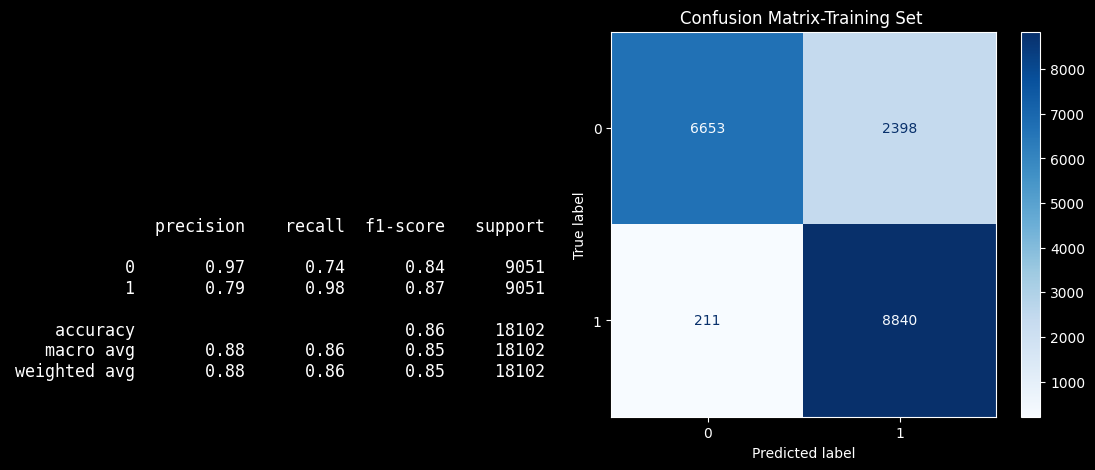

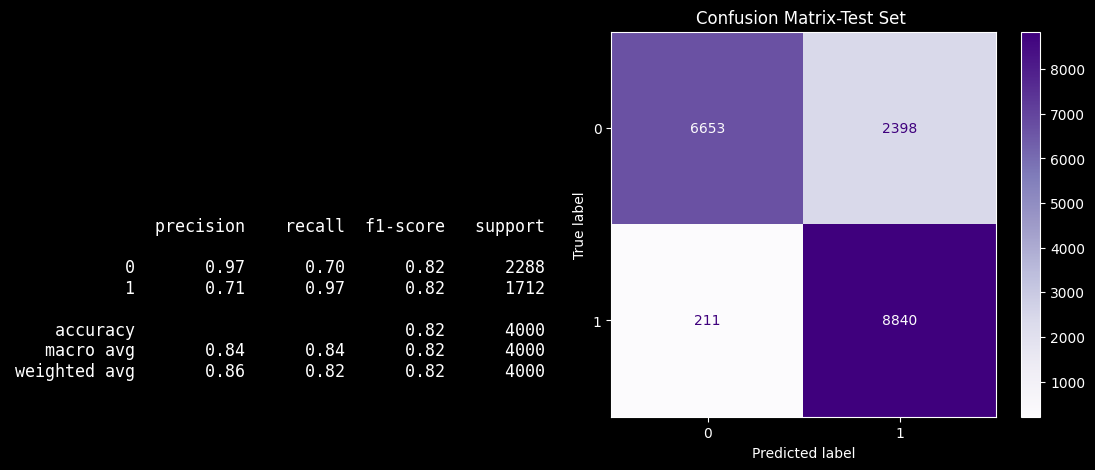

In [11]:
train_report, test_report = evaluate_model(dec_tree,X_train_balanced_df,y_train_balanced,X_test_transformed_df,y_test)

#### MODEL EVALUATION


In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure reproducibility
np.random.seed(42)

# Train the model
def train_model(model,X_train,y_train):
    model.fit(X_train,y_train)
    return model

# Get feature importance
def get_feature_importance(model,feature_names):

    importance= model.feature_importances_

    feature_importance = pd.DataFrame({
        'feature':feature_names,
        'importance':importance

    }).sort_values(by='importance',ascending=False)

    return feature_importance

# Plot the features
def plot_feature_importance(feature_importance, title):

    plt.figure(figsize=(10,6))

    # Barplot
    sns.barplot(
        x='importance',
        y='feature',
        data=feature_importance,
        palette='viridis',
        hue='feature'
    )

    plt.title(title)
    plt.xlabel('importance')
    plt.ylabel('feature')
    plt.show()

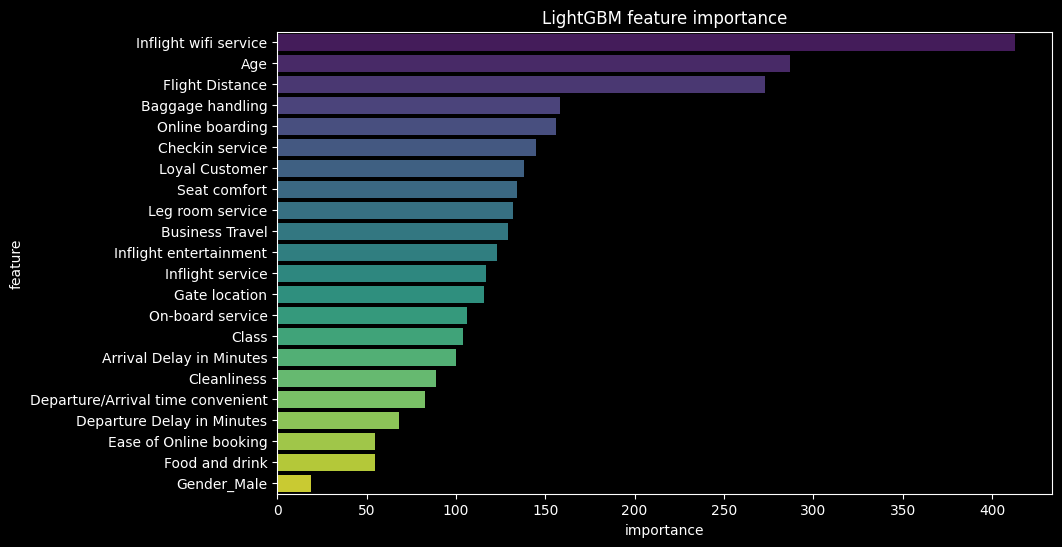

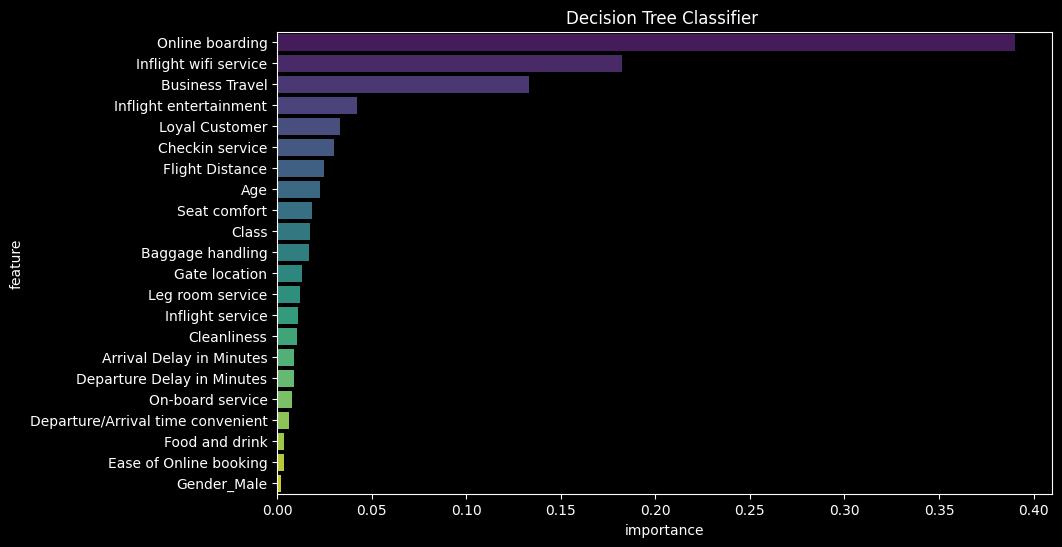

In [13]:
# Get feature names 
feature_names = X_train.columns

# Train LGBMClassifier
trained_lgbm_model = train_model(lgbm_model,X_train_balanced,y_train_balanced)

# Get and plot feature importances of the LGBMClassifier
lgbm_feature_importance = get_feature_importance(trained_lgbm_model, feature_names)
plot_feature_importance(lgbm_feature_importance, title='LightGBM feature importance')


# Train DEC_TREE
trained_dec_tree = train_model(dec_tree,X_train_balanced,y_train_balanced)

# Get and plot feature importances of the DecisionTreeClassifier
dec_feature_importance = get_feature_importance(trained_dec_tree, feature_names)
plot_feature_importance(dec_feature_importance, title='Decision Tree Classifier ')



1. Online boarding
2. Inflight wifi service
3. Business travel
4. Inflight entertainment
5. Loyal Customer
6. 
7. 
8. 
9. 
10. 
